In [ ]:
# %%

import numpy as np
import pandas as pd
from nelson_langer_network import build_nelson_network
import time
from astrochem_clustering import AstrochemClusterModel

# Load parameters
datafile = np.load('data/tracer_parameter_data.npy')
datafile[:,0] *= 2
# ['nH', 'T', 'XH2', 'FUV', 'NH', 'zeta'] are the columns of datafile
data = datafile[:,[0, 1, 3]]
# data = datafile[:,[0, 1]]
data[:,[0,1]] = np.log10(data[:,[0,1]])
# data[:,2] /= 8.94e-14
params = pd.DataFrame(data=data, columns=['$\log(n_h)$', '$\log(T)$', '$G_0$'])

# Data for ode solves
# [H_2, H_3^+, e, He, He^+, C, CH_x, O, OH_x, CO, HCO^+, C^+, M^+, M]
#  0    1      2  3   4     5  6     7  8     9   10     11   12   13

# These are the initial conditions used by Nina in her testing code
x0 = np.array([
    0.5,
    9.059e-9,
    2e-4,
    0.1,
    7.866e-7,
    0.0,
    0.0,
    0.0004,
    0.0,
    0.0,
    0.0,
    0.0002,
    2.0e-7,
    2.0e-7
])
# From the overleaf doc
# x0 = np.array([
    # what should go here anyways?
# ])

secs_per_year = 3600*24*365
tf = 1000 * secs_per_year


def solve_nelson_network(params_row: np.ndarray, x0: np.ndarray, QoI: np.ndarray, time: float):
    n_h = 10**params_row[0]
    T = 10**params_row[1]
    G0 = params_row[2]
    network = build_nelson_network(n_h = n_h, T = T, G0 = G0)
    tvec, yvec = network.solve_reaction([0, time], x0)
    return yvec[QoI, -1]

In [ ]:
# %% Load medium dataset (with ode solves)

foo = np.load('data/medium_dataset_with_ode_solves.npy')
medium_dataset = pd.DataFrame(data=foo, columns=[
    '$\log(n_h)$',
    '$\log(T)$',
    '$G_0$',
    'e (t=100Y)',
    'H_2 (t=100Y)',
    'H_3+ (t=100Y)',
    'CO (t=100Y)',
    'C (t=100Y)',
    'e (t=1000Y)',
    'H_2 (t=1000Y)',
    'H_3+ (t=1000Y)',
    'CO (t=1000Y)',
    'C (t=1000Y)',
    'e (t=10000Y)',
    'H_2 (t=10000Y)',
    'H_3+ (t=10000Y)',
    'CO (t=10000Y)',
    'C (t=10000Y)',
])
np.random.seed(1234)
msk = np.random.rand(len(medium_dataset)) > 0.2
train = medium_dataset[msk]
test = medium_dataset[~msk]

In [ ]:
# %% Train model

start_time = time.perf_counter()
surrogate = AstrochemClusterModel()
surrogate.train_surrogate_model(train.reset_index(drop=True), 0.01, [2, 0, 1, 9, 5], x0, tf, 10, 10, False, [8,9,10,11,12])
end_time = time.perf_counter()

total_time = end_time - start_time # in seconds
print(f'Training time: {total_time:.2f} seconds')

Training time: 7031.87 seconds


In [ ]:
# %% If we want to save the surrogate, we need to use pickle 

import pickle
with open(f'data/medium_model_tf_{tf}_tol_1.0.pkl', 'wb') as file:
    pickle.dump(surrogate, file)

In [ ]:
surrogate.N_clusters

31979

In [ ]:
# %% Test Model

start_time = time.perf_counter()
datamat = np.zeros(shape=(len(test),19))
# Exact solution for e, H2, H3+, CO, C in columns 0-4
# Index in column 5
# Predictions in columns 6-10
# Errors in columns 11-15
# Test data in columns 16-18
j = 0
for index, row in test.iterrows():
    datamat[j, [0,1,2,3,4]] = medium_dataset.iloc[index, [8,9,10,11,12]].to_numpy()
    # datamat[j, [0,1,2,3,4]] = solve_nelson_network(row.to_numpy()[0:3], x0, [2,0,1,9,5], tf)
    j += 1
mid_time = time.perf_counter()
datamat[:,[5,6,7,8,9,10]] = surrogate.predict(test[['$\log(n_h)$','$\log(T)$','$G_0$']].to_numpy())
end_time = time.perf_counter()
print(f'Time to solve all ODEs: {mid_time-start_time} seconds')
print(f'Time to predict data: {end_time-mid_time}')
datamat[:,[11,12,13,14,15]] = np.abs(datamat[:,[6,7,8,9,10]] - datamat[:,[0,1,2,3,4]]) / np.abs(datamat[:,[0,1,2,3,4]])
datamat[:,[16,17,18]] = test[['$\log(n_h)$','$\log(T)$','$G_0$']].to_numpy()

Time to solve all ODEs: 0.5666006660030689 seconds
Time to predict data: 0.011605750012677163


(array([6.653e+03, 2.088e+03, 1.269e+03, 7.280e+02, 4.490e+02, 2.250e+02,
        1.630e+02, 9.100e+01, 4.800e+01, 4.600e+01, 3.200e+01, 2.500e+01,
        2.100e+01, 1.100e+01, 1.800e+01, 1.000e+01, 7.000e+00, 9.000e+00,
        6.000e+00, 7.000e+00, 6.000e+00, 2.000e+00, 5.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 0.000e+00]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]),
 <BarContainer object of 29 artists>)

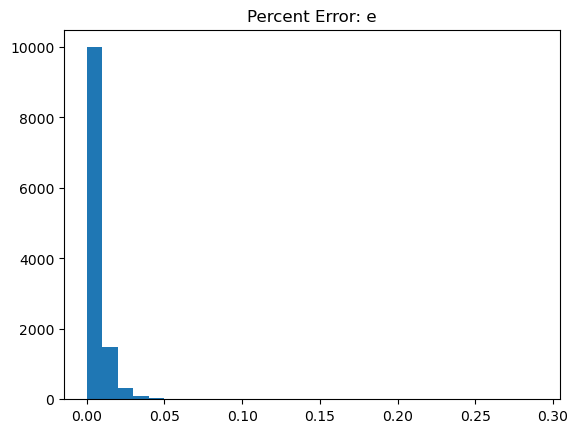

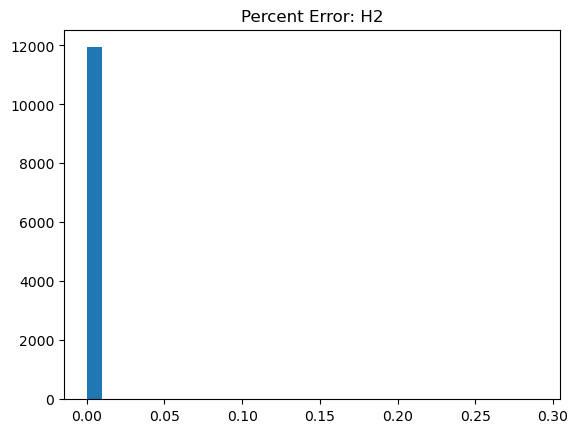

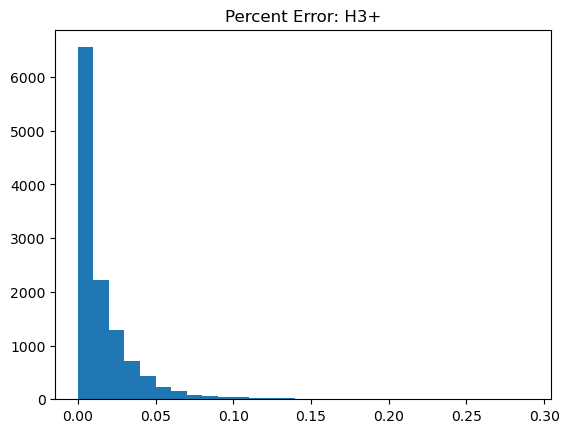

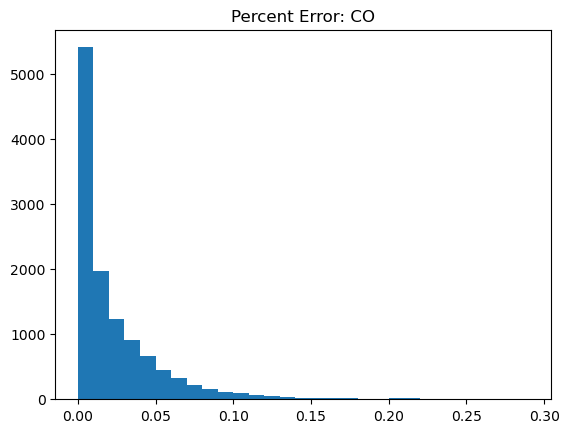

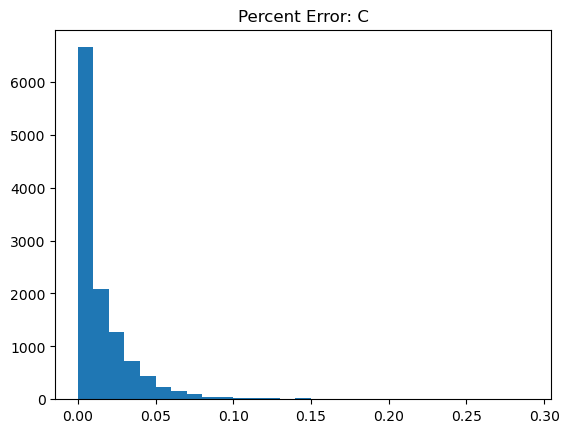

In [ ]:
# %%

import matplotlib.pyplot as plt
plt.figure()
plt.title('Percent Error: e')
plt.hist(datamat[:,11], bins=np.arange(0, 0.3, 0.01))
plt.figure()
plt.title('Percent Error: H2')
plt.hist(datamat[:,12], bins=np.arange(0, 0.3, 0.01))
plt.figure()
plt.title('Percent Error: H3+')
plt.hist(datamat[:,13], bins=np.arange(0, 0.3, 0.01))
plt.figure()
plt.title('Percent Error: CO')
plt.hist(datamat[:,14], bins=np.arange(0, 0.3, 0.01))
plt.figure()
plt.title('Percent Error: C')
plt.hist(datamat[:,15], bins=np.arange(0, 0.3, 0.01))